In [1]:
import nibabel as nib
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
from tensorflow.keras import layers, models, callbacks, metrics, Input, Model, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from skimage.transform import rotate
import random

In [2]:
def calculate_label(image, threshold=0.010):
    """
    Determina o label da subimagem com base no percentual de fundo não-preto.
    :param subimage: Array da subimagem.
    :param threshold: Percentual mínimo de fundo não-preto para considerar como label 1.
    :return: String indicando o label.
    """
    # Total de pixels na subimagem
    total_pixels = image.size
    # Número de pixels não-preto
    non_zero_pixels = np.count_nonzero(image)
    # Proporção de pixels não-preto
    non_black_ratio = non_zero_pixels / total_pixels if total_pixels > 0 else 0
    
    # Verifica se há lesão e se o fundo não-preto é maior que o limiar
    if np.any(image == 1) and non_black_ratio >= threshold:
        return 1
    else:
        return 0

# Função que carrega os dados com pares de imagens
def load_data_with_pairs(folder):
    if not os.path.exists(folder):
        print(f"A pasta {folder} não existe.")
        return {}, {}, {}, {}, {}
    
    images_left = {}
    images_right = {}
    mask_left = {}
    mask_right = {}
    labels_left = {}
    labels_right = {}
    patient_ids = []

    # Itera sobre os pacientes no diretório
    for patient_id in tqdm(os.listdir(folder), desc="Carregamento de arquivos NIfTI..."):
        patient_path = os.path.join(folder, patient_id)

        areas_image = ["left", "right"]
        areas_mask = ["lesion_left", "lesion_right"]
        path_left = os.path.join(patient_path, areas_image[0])
        path_right = os.path.join(patient_path, areas_image[1])
        lesion_path_left = os.path.join(patient_path, areas_mask[0])
        lesion_path_right = os.path.join(patient_path, areas_mask[1])

        if patient_id not in images_left:
            images_left[patient_id] = []
        if patient_id not in images_right:
            images_right[patient_id] = []
        if patient_id not in mask_left:
            mask_left[patient_id] = []
        if patient_id not in mask_right:
            mask_right[patient_id] = []
        if patient_id not in labels_left:
            labels_left[patient_id] = []
        if patient_id not in labels_right:
            labels_right[patient_id] = []
                    
        # Carrega as imagens e máscaras do lado esquerdo
        for patch_id, mask_id in zip(os.listdir(path_left), os.listdir(lesion_path_left)):
            img_path= os.path.join(path_left, patch_id)
            mask_path = os.path.join(lesion_path_left, mask_id)
            for img_path_left, mask_path_left in zip(os.listdir(img_path), os.listdir(mask_path)):
                image_data_left = nib.load(os.path.join(img_path, img_path_left)).get_fdata()
                mask_data_left = nib.load(os.path.join(mask_path, mask_path_left)).get_fdata()

                images_left[patient_id].append(image_data_left)
                mask_left[patient_id].append(mask_data_left)

                labels_left[patient_id].append(calculate_label(mask_data_left))

        # Carrega as imagens e máscaras do lado direito
        for patch_id, mask_id in zip(os.listdir(path_right), os.listdir(lesion_path_right)):
            img_path = os.path.join(path_right, patch_id)
            mask_path = os.path.join(lesion_path_right, mask_id)
            for img_path_right, mask_path_right in zip(os.listdir(img_path), os.listdir(mask_path)):
                image_data_right = nib.load(os.path.join(img_path, img_path_right)).get_fdata()
                mask_data_right = nib.load(os.path.join(mask_path, mask_path_right)).get_fdata()

                image_data_right = np.fliplr(image_data_right)
                mask_data_right = np.fliplr(mask_data_right)
                
                images_right[patient_id].append(image_data_right)
                mask_right[patient_id].append(mask_data_right)
                
                labels_right[patient_id].append(calculate_label(mask_data_right))
        patient_ids.append(patient_id)

    # Estruturas para armazenar os pares de labels
    labels_pair = {}
    for patient_id,_ in zip(labels_left.keys(), labels_right.keys()):
        labels_pair[patient_id] = []
        for label_left, label_right in zip(labels_left[patient_id], labels_right[patient_id]): 
            if label_left == 0 and label_right == 0:
                labels_pair[patient_id].append(0)
            else:
                labels_pair[patient_id].append(1)

    print(f"Total de pacientes: {len(patient_ids)}")
    for patient_id, labels in labels_pair.items():
        print(f"Paciente {patient_id}: Total de pares de recortes: {len(labels)}")

    return images_left, images_right, labels_pair, mask_left, mask_right

In [3]:
# Função de data augmentation revisada
def augment_data(images_original, images_opposite, labels, augment_factor=1):
    augmented_images_original = []
    augmented_images_opposite = []
    augmented_labels = []

    for i in range(len(labels)):
        original = images_original[i]
        opposite = images_opposite[i]
        label = labels[i]

        augmented_images_original.append(original)
        augmented_images_opposite.append(opposite)
        augmented_labels.append(label)

        for _ in range(augment_factor - 1):
            angle = random.uniform(-15, 15)
            augmented_original = rotate(original, angle, mode='wrap')
            augmented_opposite = rotate(opposite, angle, mode='wrap')
            
            augmented_images_original.append(augmented_original)
            augmented_images_opposite.append(augmented_opposite)
            augmented_labels.append(label)

    # Converter listas em arrays numpy após garantir a homogeneidade de forma e tipo
    return augmented_images_original, augmented_images_opposite, augmented_labels


In [4]:
# Função para filtrar as imagens por paciente
def select_by_patients(patients, all_images_original, all_images_opposite, all_labels):
    selected_images_original = []
    selected_images_opposite = []
    selected_labels = []
    
    for patient in patients:
        if patient in all_images_original and patient in all_images_opposite:
            selected_images_original.extend(all_images_original[patient])
            selected_images_opposite.extend(all_images_opposite[patient])
            selected_labels.extend(all_labels[patient])
        else:
            print(f"Paciente {patient} não encontrado em uma das listas de imagens.")
    
    return (selected_images_original), (selected_images_opposite), selected_labels

In [5]:
# Função para preparar os dados para treino, validação e teste
def prepare_data_for_training_balanced(images_left, images_right, labels_pair, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1, augment_factor=1):
    balanced_images_original = {}
    balanced_images_opposite = {}
    balanced_labels = {}
    balanced_mask_original = {}
    balanced_mask_opposite = {}

    for patient_id in images_left:
        class_1_labels = []
        class_0_labels = []
        class_1_left = {}
        class_0_left = {}
        class_1_right = {}
        class_0_right = {}
        class_1_mask_left = {}
        class_0_mask_left = {}
        class_1_mask_right = {}
        class_0_mask_right = {}
        
        class_1_left[patient_id] = []
        class_0_left[patient_id] = []
        class_1_right[patient_id] = []
        class_0_right[patient_id] = []
        class_1_mask_left[patient_id] = []
        class_0_mask_left[patient_id] = []
        class_1_mask_right[patient_id] = []
        class_0_mask_right[patient_id] = []
        index = 0
        
        # Iterar sobre os patches e dividir as classes 0 e 1 com base nas labels
        for label in labels_pair[patient_id]:
            image_left = (images_left[patient_id])[index]
            image_right = (images_right[patient_id])[index]
            mask_image_left = (mask_left[patient_id])[index]
            mask_image_right = (mask_right[patient_id])[index]
            index += 1
            
            if label == 1:
                class_1_labels.append(label)
                class_1_left[patient_id].append(image_left)
                class_1_right[patient_id].append(image_right)
                class_1_mask_left[patient_id].append(mask_image_left)
                class_1_mask_right[patient_id].append(mask_image_right)
            else:
                class_0_labels.append(label)
                class_0_left[patient_id].append(image_left)
                class_0_right[patient_id].append(image_right)
                class_0_mask_left[patient_id].append(mask_image_left)
                class_0_mask_right[patient_id].append(mask_image_right)
        
        class_1_count = len(class_1_labels)
        print(f"Paciente {patient_id}: Total de pares de recortes com labels 1: {class_1_count}")

        # Fazer undersampling da classe majoritária (label 0) para igualar ao número de exemplos da classe 1
        class_0_count = len(class_0_labels)
        if class_0_count > class_1_count:
            sampled_class_0_slices_left = (class_0_left[patient_id])[:class_1_count]
            sampled_class_0_slices_right = (class_0_right[patient_id])[:class_1_count]
            class_0_original_modified = {}
            class_0_original_modified[patient_id] = []
            class_0_opposite_modified = {}
            class_0_opposite_modified[patient_id] = []
            sampled_class_0_mask_left = (class_0_mask_left[patient_id])[:class_1_count]
            sampled_class_0_mask_right = (class_0_mask_right[patient_id])[:class_1_count]
            class_0_mask_original_modified = {}
            class_0_mask_original_modified[patient_id] = []
            class_0_mask_opposite_modified = {}
            class_0_mask_opposite_modified[patient_id] = []
            
            for left_image, left_mask in zip(sampled_class_0_slices_left, sampled_class_0_mask_left):
                class_0_original_modified[patient_id].append(left_image)
                class_0_mask_original_modified[patient_id].append(left_mask)
            for right_image, right_mask in zip(sampled_class_0_slices_right, sampled_class_0_mask_right):
                class_0_opposite_modified[patient_id].append(right_image)
                class_0_mask_opposite_modified[patient_id].append(right_mask)
            class_0_labels = [0] * class_1_count

        balanced_images_original[patient_id] = list(class_1_left[patient_id]) + list(class_0_original_modified[patient_id])
        balanced_images_opposite[patient_id] = list(class_1_right[patient_id]) + list(class_0_opposite_modified[patient_id])
        balanced_labels[patient_id] = class_1_labels + class_0_labels
        balanced_mask_original[patient_id] = list(class_1_mask_left[patient_id]) + list(class_0_mask_original_modified[patient_id])
        balanced_mask_opposite[patient_id] = list(class_1_mask_right[patient_id]) + list(class_0_mask_opposite_modified[patient_id])

    for patient_id, images in balanced_images_original.items():
        print(f"Paciente {patient_id}: Total de pares de recortes (label 1 + label 0): {len(images)}")
        
    # Separar os dados por conjunto (treino, validação, teste)
    patients = list(set(balanced_labels.keys()))
    train_patients, valtest_patients = train_test_split(patients, train_size = train_size)
    val_patients, test_patients = train_test_split(valtest_patients, train_size = validation_size / (validation_size + test_size))
    
    X_train_original, X_train_opposite, y_train = select_by_patients(train_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_val_original, X_val_opposite, y_val = select_by_patients(val_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    X_test_original, X_test_opposite, y_test = select_by_patients(test_patients, balanced_images_original, balanced_images_opposite, balanced_labels)
    mask_test_original, mask_test_opposite, _ = select_by_patients(test_patients, balanced_mask_original, balanced_mask_opposite, balanced_labels)

    # Aplicar data augmentation nas imagens
    # X_train_original_, X_train_opposite_, y_train = augment_data(X_train_original, X_train_opposite, y_train, augment_factor=augment_factor)
    # X_val_original_, X_val_opposite_, y_val = augment_data(X_val_original, X_val_opposite, y_val, augment_factor=augment_factor)
    # X_test_original_, X_test_opposite_, y_test = augment_data(X_test_original, X_test_opposite, y_test, augment_factor=augment_factor)
    
    X_train_original = [img for img in X_train_original if len(img)>0 and img is not []]
    X_train_opposite = [img for img in X_train_opposite if len(img)>0 and img is not []]
    X_val_original = [img for img in X_val_original if len(img)>0 and img is not []]
    X_val_opposite = [img for img in X_val_opposite if len(img)>0 and img is not []]
    X_test_original = [img for img in X_test_original if len(img)>0 and img is not []]
    X_test_opposite = [img for img in X_test_opposite if len(img)>0 and img is not []]
    mask_test_original = [img for img in mask_test_original if len(img)>0 and img is not []]
    mask_test_opposite = [img for img in mask_test_opposite if len(img)>0 and img is not []]

    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 1: {y_train.count(1)}")
    print(f"Total de pares de recortes no treino ({augment_factor}*{train_patients}) com label 0: {y_train.count(0)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 1: {y_val.count(1)}")
    print(f"Total de pares de recortes na validação ({augment_factor}*{val_patients}) com label 0: {y_val.count(0)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 1: {y_test.count(1)}")
    print(f"Total de pares de recortes no teste com ({augment_factor}*{test_patients}) label 0: {y_test.count(0)}")
    
    return np.array(X_train_original), np.array(X_train_opposite), np.array(X_val_original), np.array(X_val_opposite), np.array(X_test_original), np.array(X_test_opposite), np.array(y_train), np.array(y_val), np.array(y_test), mask_test_original, mask_test_opposite

In [6]:
# Função para construir o modelo CNN 2D
def build_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3,3), data_format="channels_last", activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(64, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3)))
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2D(128, (3,3), data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3))) 
    model.add(layers.Dropout(0.5)) 
    
    model.add(layers.Conv2D(256, (3,3), padding="same", data_format="channels_last", activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((3,3), padding="same")) 
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.01)))

    return model

In [7]:
# Função para construir a rede siamesa
def build_siamese_model(input_shape_original, input_shape_opposite):
    input_original = Input(shape=input_shape_original)
    input_opposite = Input(shape=input_shape_opposite)

    cnn_model = build_cnn_model(input_shape_original)
    output_original = cnn_model(input_original)
    cnn_model_opposite = build_cnn_model(input_shape_opposite)
    output_opposite = cnn_model_opposite(input_opposite)

    # Concatenar as duas saídas (Lado esquerdo + Contra-lateral)
    concatenated = layers.Concatenate()([output_original, output_opposite])
    concatenated = layers.BatchNormalization()(concatenated)
    
    output = layers.Dense(1, activation='sigmoid')(concatenated)
    
    siamese_model = Model(inputs=[input_original, input_opposite], outputs=output)
    siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', metrics.Precision(name="precision"), metrics.Recall(name="recall")])

    return siamese_model

In [8]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Graphic')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


In [9]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()


In [10]:
input_folder = 'Contralateral'

# Carregar os dados
X_left, X_right, y, mask_left, mask_right = load_data_with_pairs(input_folder)

Carregamento de arquivos NIfTI...: 100%|██████████| 41/41 [13:01<00:00, 19.05s/it]

Total de pacientes: 41
Paciente sub-00H10: Total de pares de recortes: 512
Paciente sub-02A13: Total de pares de recortes: 528
Paciente sub-03C08: Total de pares de recortes: 484
Paciente sub-06C09: Total de pares de recortes: 492
Paciente sub-14F04: Total de pares de recortes: 520
Paciente sub-16E03: Total de pares de recortes: 552
Paciente sub-16G09: Total de pares de recortes: 516
Paciente sub-16I12: Total de pares de recortes: 540
Paciente sub-19F09: Total de pares de recortes: 544
Paciente sub-19G04: Total de pares de recortes: 496
Paciente sub-25B08: Total de pares de recortes: 544
Paciente sub-26B09: Total de pares de recortes: 512
Paciente sub-29D03: Total de pares de recortes: 488
Paciente sub-35E12: Total de pares de recortes: 520
Paciente sub-36K02: Total de pares de recortes: 524
Paciente sub-41D08: Total de pares de recortes: 504
Paciente sub-42B05: Total de pares de recortes: 528
Paciente sub-42K06: Total de pares de recortes: 508
Paciente sub-44H05: Total de pares de rec

In [11]:
# Preparar dados para treino, teste e validação
X_train_left, X_train_right, X_valid_left, X_valid_right, X_test_left, X_test_right, y_train, y_valid, y_test, mask_left_test, mask_right_test = prepare_data_for_training_balanced(X_left, X_right, y, mask_left, mask_right, train_size=0.7, validation_size=0.2, test_size=0.1)
    
# Adiciono camada de cor
X_train_left = np.expand_dims(X_train_left, axis=-1)
X_train_right = np.expand_dims(X_train_right, axis=-1)
X_valid_left = np.expand_dims(X_valid_left, axis=-1)
X_valid_right = np.expand_dims(X_valid_right, axis=-1)
X_test_left = np.expand_dims(X_test_left, axis=-1)
X_test_right = np.expand_dims(X_test_right, axis=-1)

Paciente sub-00H10: Total de pares de recortes com labels 1: 41
Paciente sub-02A13: Total de pares de recortes com labels 1: 25
Paciente sub-03C08: Total de pares de recortes com labels 1: 52
Paciente sub-06C09: Total de pares de recortes com labels 1: 79
Paciente sub-14F04: Total de pares de recortes com labels 1: 34
Paciente sub-16E03: Total de pares de recortes com labels 1: 102
Paciente sub-16G09: Total de pares de recortes com labels 1: 62
Paciente sub-16I12: Total de pares de recortes com labels 1: 28
Paciente sub-19F09: Total de pares de recortes com labels 1: 128
Paciente sub-19G04: Total de pares de recortes com labels 1: 144
Paciente sub-25B08: Total de pares de recortes com labels 1: 37
Paciente sub-26B09: Total de pares de recortes com labels 1: 88
Paciente sub-29D03: Total de pares de recortes com labels 1: 18
Paciente sub-35E12: Total de pares de recortes com labels 1: 120
Paciente sub-36K02: Total de pares de recortes com labels 1: 47
Paciente sub-41D08: Total de pares d

In [12]:
# Construir e compilar o modelo CNN
input_shape_left = (X_train_left[0].shape)
input_shape_right = (X_train_right[0].shape)

siamese_model = build_siamese_model(input_shape_left, input_shape_right)
siamese_model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60, 60, 1)]          0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60, 60, 1)]          0         []                            
                                                                                                  
 sequential (Sequential)     (None, 256)                  455552    ['input_1[0][0]']             
                                                                                                  
 sequential_1 (Sequential)   (None, 256)                  455552    ['input_2[0][0]']             
                                                                                            

In [13]:
# Adicionar o callback EarlyStopping e low rate scheduler
# early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Treinamento do modelo  
history = siamese_model.fit([X_train_left, X_train_right], y_train, validation_data=([X_valid_left, X_valid_right], y_valid), batch_size=64, epochs=120)

Epoch 1/120


66/66 [==============================] - 14s 115ms/step - loss: 67.8846 - accuracy: 0.5586 - precision: 0.5645 - recall: 0.5126 - val_loss: 63.9587 - val_accuracy: 0.5000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/120
66/66 [==============================] - 6s 97ms/step - loss: 60.4465 - accuracy: 0.5965 - precision: 0.6048 - recall: 0.5567 - val_loss: 56.7984 - val_accuracy: 0.5035 - val_precision: 0.7500 - val_recall: 0.0105
Epoch 3/120
66/66 [==============================] - 7s 101ms/step - loss: 53.4806 - accuracy: 0.6311 - precision: 0.6426 - recall: 0.5908 - val_loss: 50.0870 - val_accuracy: 0.5918 - val_precision: 0.6134 - val_recall: 0.4965
Epoch 4/120
66/66 [==============================] - 7s 111ms/step - loss: 46.9840 - accuracy: 0.6588 - precision: 0.6690 - recall: 0.6287 - val_loss: 43.8306 - val_accuracy: 0.6442 - val_precision: 0.6445 - val_recall: 0.6434
Epoch 5/120
66/66 [==============================] - 8s 121ms/step - loss: 40.9545

In [14]:
# Avaliar o modelo
y_pred = (siamese_model.predict([X_test_left, X_test_right]) >=  0.5)

# Gerar o relatório de classificação
print(classification_report(y_test, y_pred))

26/26 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.63      0.75      0.68       411
           1       0.69      0.56      0.62       411

    accuracy                           0.65       822
   macro avg       0.66      0.65      0.65       822
weighted avg       0.66      0.65      0.65       822



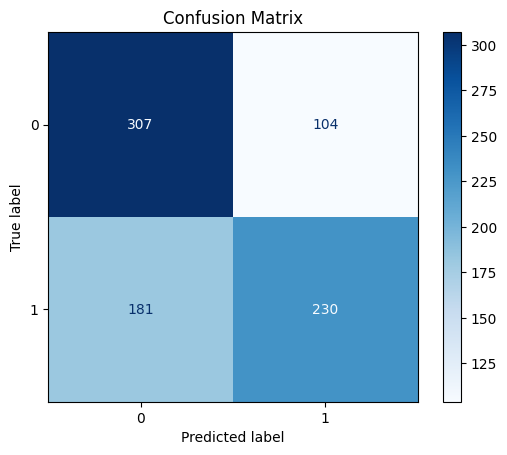

In [15]:
# Gerar a matriz de confusão
plot_confusion_matrix(y_test, y_pred)

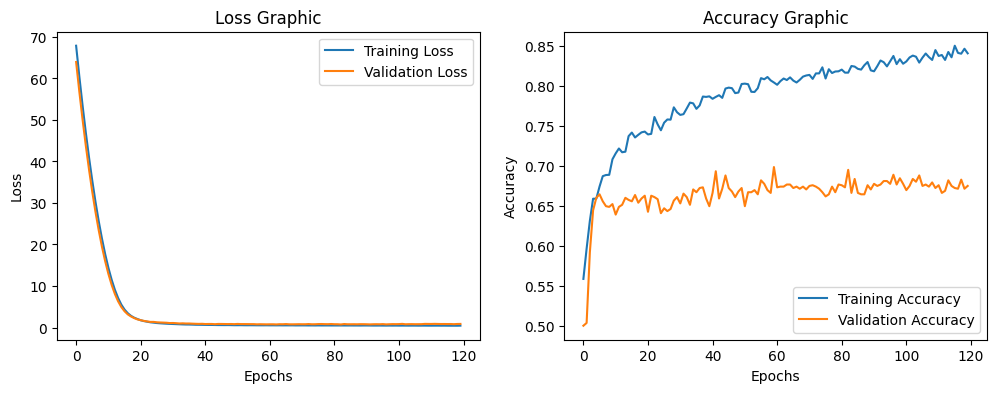

In [16]:
# Plotar o histórico do treinamento
plot_training_history(history)

In [18]:
# Função para plotar e salvar as imagens com legenda no PDF
def plot_images_to_pdf(X_test_left, X_test_right, y_test, y_pred, mask_left_test, mask_right_test, pdf_path1='Pdf/Pacientes_Conjunto_Teste_FN.pdf', pdf_path2='Pdf/Pacientes_Conjunto_Teste_FP.pdf', pdf_path3='Pdf/Pacientes_Conjunto_Teste_TN.pdf', pdf_path4='Pdf/Pacientes_Conjunto_Teste_TP.pdf'):
    # Abre o arquivo PDF para escrita
    with PdfPages(pdf_path1) as pdf:
        for i in range(len(y_test)):
            if y_pred[i] == 1:
                label_pred = "Sim"
            else:
                label_pred = "Não"
            if y_test[i] == 1:
                label_verd = "Sim"
            else:
                label_verd = "Não"
            if (label_pred == "Não" and label_verd == "Sim"):
                # Exibe progresso
                print(f"Processando imagem {i + 1} de {len(y_pred)}")

                # Configuração da figura
                fig, axs = plt.subplots(2, 2, figsize=(4, 4))
                #fig.suptitle(f'Label Pred.: {label_pred}  -  Label Verd.: {label_verd}')

                # Exibe as imagens
                axs[0,0].imshow(X_test_left[i], cmap='gray')
                axs[0,0].set_title(f'MRI Esquerda-{i}')
                axs[0,0].axis('off')

                axs[1,0].imshow(mask_left_test[i], cmap='gray')
                axs[1,0].set_title(f'Mask Esquerda-{i}')
                axs[1,0].axis('off')
                
                axs[0,1].imshow(X_test_right[i], cmap='gray')
                axs[0,1].set_title(f'MRI Direita-{i}')
                axs[0,1].axis('off')

                axs[1,1].imshow(mask_right_test[i], cmap='gray')
                axs[1,1].set_title(f'Mask Direita-{i}')
                axs[1,1].axis('off')
                
                # Adiciona a figura atual ao PDF
                pdf.savefig(fig)
                plt.close(fig)
    print(f"As imagens foram salvas no arquivo PDF '{pdf_path1}' com sucesso.")

    # Abre o arquivo PDF para escrita
    with PdfPages(pdf_path2) as pdf:
        for i in range(len(y_test)):
            if y_pred[i] == 1:
                label_pred = "Sim"
            else:
                label_pred = "Não"
            if y_test[i] == 1:
                label_verd = "Sim"
            else:
                label_verd = "Não"
            if (label_pred == "Sim" and label_verd == "Não"):
                # Exibe progresso
                print(f"Processando imagem {i + 1} de {len(y_pred)}")

                # Configuração da figura
                fig, axs = plt.subplots(2, 2, figsize=(4, 4))
                #fig.suptitle(f'Label Pred.: {label_pred}  -  Label Verd.: {label_verd}')

                # Exibe as imagens
                axs[0,0].imshow(X_test_left[i], cmap='gray')
                axs[0,0].set_title(f'MRI Esquerda-{i}')
                axs[0,0].axis('off')

                axs[1,0].imshow(mask_left_test[i], cmap='gray')
                axs[1,0].set_title(f'Mask Esquerda-{i}')
                axs[1,0].axis('off')
                
                axs[0,1].imshow(X_test_right[i], cmap='gray')
                axs[0,1].set_title(f'MRI Direita-{i}')
                axs[0,1].axis('off')

                axs[1,1].imshow(mask_right_test[i], cmap='gray')
                axs[1,1].set_title(f'Mask Direita-{i}')
                axs[1,1].axis('off')
                
                # Adiciona a figura atual ao PDF
                pdf.savefig(fig)
                plt.close(fig)
    print(f"As imagens foram salvas no arquivo PDF '{pdf_path2}' com sucesso.")
    
    with PdfPages(pdf_path3) as pdf:
        for i in range(len(y_test)):
            if y_pred[i] == 1:
                label_pred = "Sim"
            else:
                label_pred = "Não"
            if y_test[i] == 1:
                label_verd = "Sim"
            else:
                label_verd = "Não"
            if (label_pred == "Não" and label_verd == "Não"):
                # Exibe progresso
                print(f"Processando imagem {i + 1} de {len(y_pred)}")

                # Configuração da figura
                fig, axs = plt.subplots(2, 2, figsize=(4, 4))
                #fig.suptitle(f'Label Pred.: {label_pred}  -  Label Verd.: {label_verd}')

                # Exibe as imagens
                axs[0,0].imshow(X_test_left[i], cmap='gray')
                axs[0,0].set_title(f'MRI Esquerda-{i}')
                axs[0,0].axis('off')

                axs[1,0].imshow(mask_left_test[i], cmap='gray')
                axs[1,0].set_title(f'Mask Esquerda-{i}')
                axs[1,0].axis('off')
                
                axs[0,1].imshow(X_test_right[i], cmap='gray')
                axs[0,1].set_title(f'MRI Direita-{i}')
                axs[0,1].axis('off')

                axs[1,1].imshow(mask_right_test[i], cmap='gray')
                axs[1,1].set_title(f'Mask Direita-{i}')
                axs[1,1].axis('off')
                
                # Adiciona a figura atual ao PDF
                pdf.savefig(fig)
                plt.close(fig)
    print(f"As imagens foram salvas no arquivo PDF '{pdf_path3}' com sucesso.")
    
    with PdfPages(pdf_path4) as pdf:
        for i in range(len(y_test)):
            if y_pred[i] == 1:
                label_pred = "Sim"
            else:
                label_pred = "Não"
            if y_test[i] == 1:
                label_verd = "Sim"
            else:
                label_verd = "Não"
            if (label_pred == "Sim" and label_verd == "Sim"):
                # Exibe progresso
                print(f"Processando imagem {i + 1} de {len(y_pred)}")

                # Configuração da figura
                fig, axs = plt.subplots(2, 2, figsize=(4, 4))
                #fig.suptitle(f'Label Pred.: {label_pred}  -  Label Verd.: {label_verd}')

                # Exibe as imagens
                axs[0,0].imshow(X_test_left[i], cmap='gray')
                axs[0,0].set_title(f'MRI Esquerda-{i}')
                axs[0,0].axis('off')

                axs[1,0].imshow(mask_left_test[i], cmap='gray')
                axs[1,0].set_title(f'Mask Esquerda-{i}')
                axs[1,0].axis('off')
                
                axs[0,1].imshow(X_test_right[i], cmap='gray')
                axs[0,1].set_title(f'MRI Direita-{i}')
                axs[0,1].axis('off')

                axs[1,1].imshow(mask_right_test[i], cmap='gray')
                axs[1,1].set_title(f'Mask Direita-{i}')
                axs[1,1].axis('off')
                
                # Adiciona a figura atual ao PDF
                pdf.savefig(fig)
                plt.close(fig)
    print(f"As imagens foram salvas no arquivo PDF '{pdf_path4}' com sucesso.")

# Chame a função com seus dados
plot_images_to_pdf(X_test_left, X_test_right, y_test, y_pred, mask_left_test, mask_right_test)

Processando imagem 1 de 822
Processando imagem 2 de 822
Processando imagem 3 de 822
Processando imagem 4 de 822
Processando imagem 5 de 822
Processando imagem 6 de 822
Processando imagem 7 de 822
Processando imagem 8 de 822
Processando imagem 9 de 822
Processando imagem 10 de 822
Processando imagem 15 de 822
Processando imagem 91 de 822
Processando imagem 92 de 822
Processando imagem 93 de 822
Processando imagem 94 de 822
Processando imagem 95 de 822
Processando imagem 96 de 822
Processando imagem 97 de 822
Processando imagem 98 de 822
Processando imagem 99 de 822
Processando imagem 100 de 822
Processando imagem 101 de 822
Processando imagem 102 de 822
Processando imagem 103 de 822
Processando imagem 104 de 822
Processando imagem 105 de 822
Processando imagem 106 de 822
Processando imagem 107 de 822
Processando imagem 108 de 822
Processando imagem 109 de 822
Processando imagem 110 de 822
Processando imagem 111 de 822
Processando imagem 112 de 822
Processando imagem 113 de 822
Processan